# RFM clustering using DBSCAN

DBSCSAN stands for "Density-Based Spatial Clustering of Applications with Noise", it's proved efficient when your data may have outliers
or with skewed datasets.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

rfm = pd.read_csv("./../../../output/rfm.csv")
y = rfm['nb_orders']

X_train, X_test, y_train, y_test = train_test_split(rfm, y, test_size=0.2, random_state=42, stratify=y)
rfm = X_test

rfm

customer_unique_id  recency  frequency  monetary  \
53201  9271d8382e15324f1704571bb2dd3147    131.0   0.200000    208.24   
22300  3d24f8153934396ca881e3124da2dfff    113.0   0.200000    102.27   
73021  c87a62e76b9ddba752d818984e8ed12f    211.0   0.125000    439.72   
26915  49d1599dd80dedc213037342bbe43fd7    256.0   0.125000    118.57   
16899  2e4172f7fd898dac91afe1173e9cfc37    195.0   0.142857    336.99   
...                                 ...      ...        ...       ...   
5129   0e095d492a0438adb41ab4d817f16d30    460.0   0.062500    175.64   
56150  9a45034c604e0dd71ed1aad487bead72     38.0   0.500000    298.61   
11239  1e9b4f7f89af6cf3db0a5a1f92241cef    186.0   0.142857     87.64   
92343  fddc49f3423572486edbc2450ac320ad     43.0   0.500000    173.75   
14777  2880ad42ad0b51c90d580f1160103ffe    254.0   0.111111     99.82   

       nb_orders  scoring_R  scoring_F  scoring_M  scoring_RFM   segment_RFM  
53201        1.0          2          4          5           11  Bons clients  
22300        1.0          2          4          3            9  Bons clients  
73021        1.0          3          3          5           11  Bons clients  
26915        2.0          3          3          3            9  Bons clients  
16899        1.0          3          3          5           11  Bons clients  
...          ...        ...        ...        ...          ...           ...  
5129         1.0          5          1          4           10  Bons clients  
56150        1.0          1          5          5           11  Bons clients  
11239        1.0          3          3          3            9  Bons clients  
92343        1.0          1          5          4           10  Bons clients  
14777        1.0          3          3          3            9  Bons clients  

[18622 rows x 10 columns]

It's not required by DBSCAN to have variables with normal distributions, but it never hurt to scale our variables:

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers_vars = rfm[["recency", "frequency", "monetary"]]
scaler.fit(customers_vars)

scaled_customers = scaler.transform(customers_vars)

scaled_customers

array([[-0.70064481,  0.04761407,  0.17702337],
       [-0.81829319,  0.04761407, -0.25298665],
       [-0.17776313, -0.34726816,  1.11633375],
       ...,
       [-0.34116366, -0.25324858, -0.31235295],
       [-1.27581466,  1.62714299,  0.03706824],
       [ 0.10328577, -0.4203945 , -0.26292838]])

We need to determine the optimal value for epsilon (eps) and the number of samples (min_samples).
Two points are considered neighbors if the distance between the two points is below the threshold epsilon.

As stated by most of data scientists, you may chose the number of samples according to your business.
If you have no idea about the number of clusters for this kind of business, you can apply the [following formula](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf):

min_samples = 2 * (number of variables)

In our case, we have 3 variables so we select **6** as `min_samples` value.

Then we will estimate an optimal value for epsilon.

In [3]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=6).fit(scaled_customers)
distances, idx = nearest_neighbors.kneighbors(scaled_customers)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
fig = px.line(None, y=distances, title="Evaluation of epsilon")
fig.show()

It look likes a value of eps around [0.3-1.8] is optimal.

eps  n_clusters  noise_points  silhouette_score
0   0.5           6            85          0.311927
1   0.6           3            67          0.637036
2   0.7           3            41          0.635635
3   0.8           2            39          0.642066
4   0.9           2            33          0.641942
5   1.0           4            18          0.638080
6   1.1           3            16          0.638541
7   1.2           3            16          0.638541
8   1.3           2            15          0.640233
9   1.4           2            15          0.640233
10  1.5           2            14          0.640549
11  1.6           2            14          0.640549
12  1.7           2            14          0.640549
13  1.8           1            12          0.903636
14  1.9           1            11          0.908412

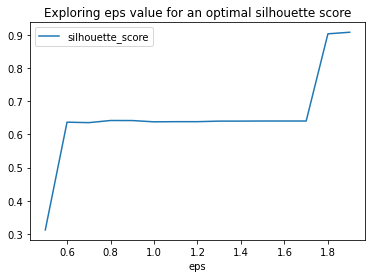

In [4]:
from sklearn import metrics
import numpy as np

# Compute DBSCAN
report = []
for eps_value in np.arange(0.5, 2, 0.1):
    dbscan = DBSCAN(eps=eps_value, min_samples=6, n_jobs=-1).fit(scaled_customers)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score = metrics.silhouette_score(scaled_customers, labels)
    report.append({
        'eps': eps_value,
        'n_clusters': n_clusters_,
        'noise_points': n_noise_,
        'silhouette_score': score
    })

df_report = pd.DataFrame(report)
df_report.plot(title="Exploring eps value for an optimal silhouette score", x='eps', y='silhouette_score')

df_report.head(15)

An optimal eps value is : **1.5** for **3** clusters

In [5]:
# Compute DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=6).fit(scaled_customers)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_customers, labels)
)

Estimated number of clusters: 2
Estimated number of noise points: 14
Silhouette Coefficient: 0.641


In [6]:
rfm["cluster"] = labels
rfm.cluster = rfm.cluster.astype("category")

#### Clustering visualisation

In [7]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)
projected_customers = tsne.fit_transform(scaled_customers)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rfm.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [8]:
# cluster for value equals to -1 is noise
rfm = rfm[rfm.cluster != -1]
fig = px.scatter_3d(rfm, x="recency", y="monetary", z="frequency", color="cluster")
fig.show()

### Conclusions on DBSCAN

Sadly, as we can see the frequency have the biggest impact and there is nothing more we can learn from this clustering if we use only RFM metrics.
If we want a better clustering, we must integrate more data.